This notebook is part of a series of notebooks that delve into the comprehensive analysis of order book events. Each notebook in this series focuses on various aspects of order book data, aiming to provide in-depth insights and understanding into the dynamics of financial markets. 

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from functools import partial
from scipy.optimize import curve_fit
import scipy
import statsmodels.api as sm

In [2]:
#load data
pair = "XCAD-USDT"
exchange = "GATEIO"

start = datetime.datetime(2022, 11, 1)
end = datetime.datetime(2022, 11, 4)

books = pd.read_parquet("/Users/miguelmeier/Jupiter_Notebook/ser_project/data/test/books_GATEIO_AVAX-USDT_2022-11-01.parquet")
trades = pd.read_parquet("/Users/miguelmeier/Jupiter_Notebook/ser_project/data/test/trades_GATEIO_AVAX-USDT_2022-11-01.parquet")

# Filter the DataFrame
#books = books[(books['received_time'] >= start) & (books['received_time'] <= end)]
#trades = trades[(trades['received_time'] >= start) & (trades['received_time'] <= end)]

## Market Microstructure

In [3]:
def smallest_increment(number):

    # Convert the number to a string and split by the decimal point
    parts = str(number).split('.')
    
    # If there's a decimal part
    if len(parts) > 1:
        # Count the number of digits after the decimal point
        decimal_places = len(parts[1])
        
        # Return the smallest increment based on the decimal places
        return 10 ** -decimal_places
    else:
        # If there's no decimal, the smallest increment is 1
        return 1

tick_size = smallest_increment(trades["price"].iloc[0])
books['mid'] = (books['bid_0_price'] + books['ask_0_price']) / 2

because there are a lot of trades happening inside the spread. i deleted it to obtain a better signal

In [4]:
# delete trades inside of spread:
delete_fake = True

#percentage of trades within spread
def find_closest_timestamp(ts, ts_list):
    """Find the closest timestamp in ts_list to ts."""
    deltas = np.abs((ts_list - ts).total_seconds())
    return ts_list[np.argmin(deltas)]
    target = row.name + pd.Timedelta(seconds=5)
    return ts_index.get_loc(target, method='nearest')

tick_size = smallest_increment(trades["price"].iloc[0])
book1 = books.copy()
# Merge trades and l1 data
book1['future_bid'] = book1.bid_0_price.shift(-1)
book1['future_ask'] = book1.ask_0_price.shift(-1)

df = pd.merge_asof(
	left = trades.rename(columns = {'received_time': 'trade_received_time'}),
	right = book1.rename(columns = {'received_time': 'depth_received_time'}),
	left_on = 'trade_received_time',
	right_on = 'depth_received_time',
	tolerance = pd.Timedelta(minutes = 60),
)
df = df.dropna().reset_index(drop = True)

# Detection logic
epsilon = tick_size
df['fake'] = (
	# Trade is fake when its inside spread (+- some epsilon, perhaps one tick)
	(df['price'] > df['bid_0_price'] + epsilon) & 
	(df['price'] < df['ask_0_price'] - epsilon) &
	# To prevent false positives, we also assume we didn't receive the next depth update yet
	(df['price'] > df['future_bid'] + epsilon) & 
	(df['price'] < df['future_ask'] - epsilon)
)

fake_volume = df.loc[df['fake'] == 1, 'quantity'].sum()
all_volume = df['quantity'].sum()

# Note that this method has some false positives, but still leads to better & cleaner data for most use cases
print('Fake trade percentage', df['fake'].mean() * 100)
print('Fake volume percentage', fake_volume / all_volume * 100)

trades = df[["side","quantity","price","trade_received_time", "origin_time_x", "fake", "trade_id"]]
trades["received_time"] =trades["trade_received_time"]

if delete_fake:
    print("drop fake trades!")
    trades = trades[~trades["fake"]]

Fake trade percentage 18.352516098953934
Fake volume percentage 39.51776397408518
drop fake trades!


/var/folders/tk/17g1mb057qd17rjwhx9x88p40000gp/T/ipykernel_29174/1202978936.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades["received_time"] =trades["trade_received_time"]


### Orderbook imbalance 


In [5]:
amount_of_rows = 1
books['ob_imbalance_1'] = (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) - sum(books[f'ask_{i}_size'] for i in range(amount_of_rows))) / (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) + sum(books[f'ask_{i}_size'] for i in range(amount_of_rows)))

amount_of_rows = 3
books['ob_imbalance_3'] = (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) - sum(books[f'ask_{i}_size'] for i in range(amount_of_rows))) / (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) + sum(books[f'ask_{i}_size'] for i in range(amount_of_rows)))

amount_of_rows = 5
books['ob_imbalance_5'] = (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) - sum(books[f'ask_{i}_size'] for i in range(amount_of_rows))) / (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) + sum(books[f'ask_{i}_size'] for i in range(amount_of_rows)))

amount_of_rows = 10
books['ob_imbalance_10'] = (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) - sum(books[f'ask_{i}_size'] for i in range(amount_of_rows))) / (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) + sum(books[f'ask_{i}_size'] for i in range(amount_of_rows)))

amount_of_rows = 20
books['ob_imbalance_20'] = (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) - sum(books[f'ask_{i}_size'] for i in range(amount_of_rows))) / (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) + sum(books[f'ask_{i}_size'] for i in range(amount_of_rows)))


#test
window = 10  

# Calculate the imbalance timeseries
books['imbalance_timeseries'] = books['bid_0_size'] - books['ask_0_size']

# Calculate the rolling mean and standard deviation
books['rolling_mean'] = books['imbalance_timeseries'].rolling(window, min_periods=1).mean()
books['rolling_std'] = books['imbalance_timeseries'].rolling(window, min_periods=1).std()

# To handle the division by zero, we'll replace zeros with a small number
books['rolling_std'] = books['rolling_std'].replace(0, np.finfo(float).eps)

# Now, standardize the imbalance timeseries
books['alpha'] = (books['imbalance_timeseries'] - books['rolling_mean']) / books['rolling_std']



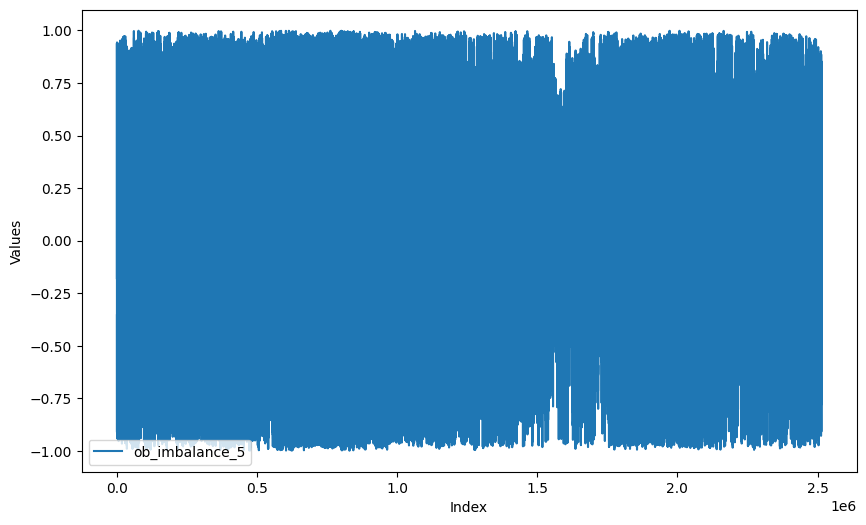

In [6]:
columns_to_plot = ["ob_imbalance_5"]

books[columns_to_plot].plot(figsize=(10, 6)) 
plt.xlabel("Index")
plt.ylabel("Values")
plt.show()

Let’s now look at some of it’s statistical properties.

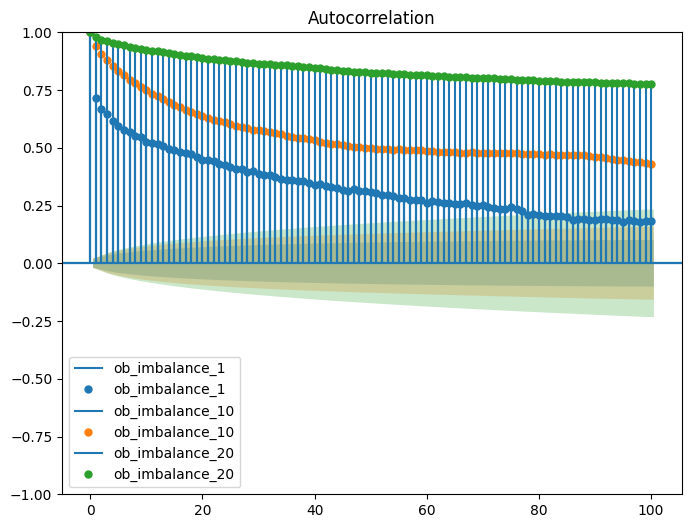

In [7]:

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the ACF of 'ob_imbalance_1' on the plot
sm.graphics.tsa.plot_acf(books['ob_imbalance_1'][-10000:], lags=100, ax=ax, label='ob_imbalance_1')
sm.graphics.tsa.plot_acf(books['ob_imbalance_10'][-10000:], lags=100, ax=ax, label='ob_imbalance_10')
sm.graphics.tsa.plot_acf(books['ob_imbalance_20'][-10000:], lags=100, ax=ax, label='ob_imbalance_20')

# Add a legend to distinguish the plots
ax.legend()

# Show the plot
plt.show()

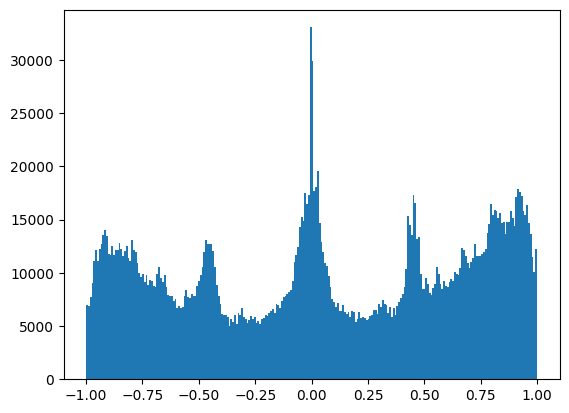

In [8]:
#Now let’s look at it’s distribution:
plt.hist([books['ob_imbalance_3']], bins=250)
plt.show()

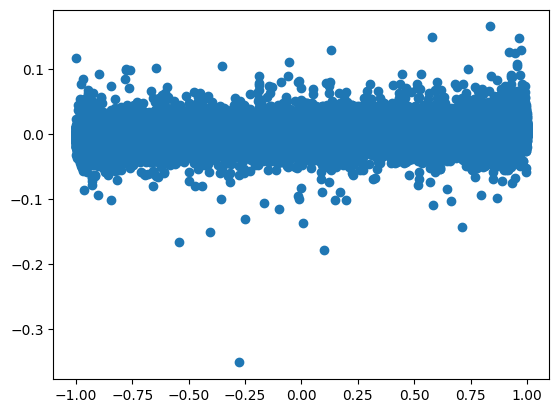

In [9]:
#books['ob_imbalance_3'] = books['ob_imbalance_3'].rolling(window=30).mean()
imbalances = np.array(books['ob_imbalance_3'])
midprices = np.array(books['mid'])
midprice_change = midprices[1:]-midprices[:-1]

plt.scatter(imbalances[:-1], midprice_change)
plt.show()



In [10]:
#what are the correlation
print(np.corrcoef(imbalances[:-1], midprices[1:]-midprices[:-1])[0][1])

0.0679043080467532


/var/folders/tk/17g1mb057qd17rjwhx9x88p40000gp/T/ipykernel_29174/2895076101.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  midprice_averages = df.groupby('imbalance_group')['midprice_change'].mean().values


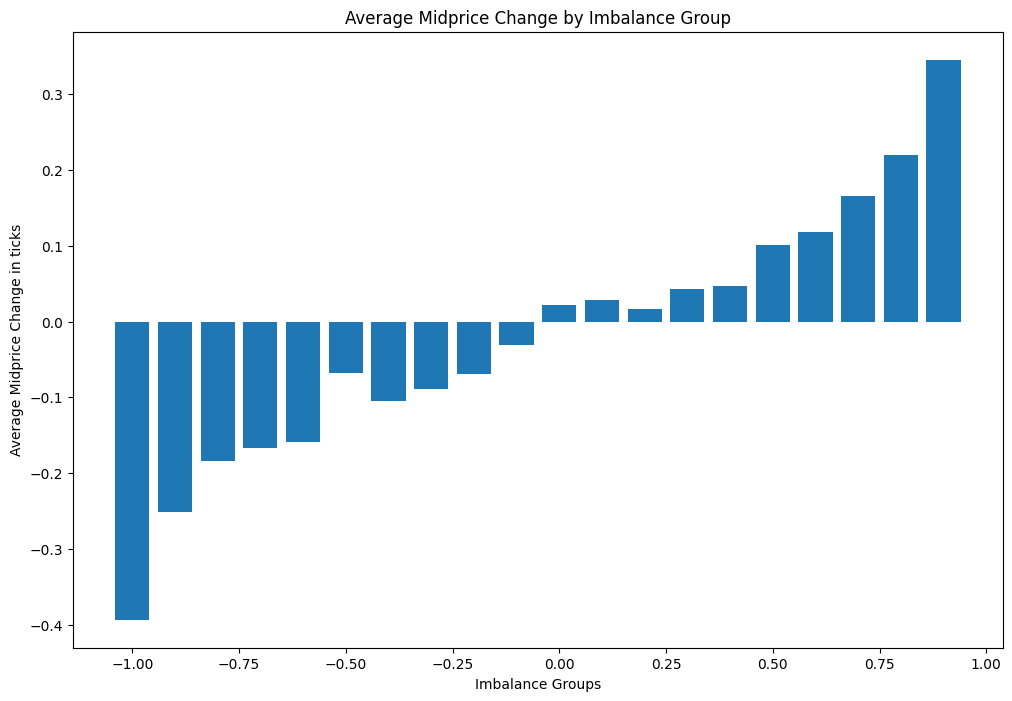

In [11]:
df = pd.DataFrame({'imbalances': imbalances[:-1], 'midprice_change': midprice_change / tick_size})

# Define the bins
bins = np.arange(-1, 1.1, 0.1)  # Adding 0.1 to include the upper bound
df['imbalance_group'] = pd.cut(df['imbalances'], bins=bins)
midprice_averages = df.groupby('imbalance_group')['midprice_change'].mean().values

imbalance_groups = np.arange(-1, 1., 0.1)
# Plotting
plt.figure(figsize=(12, 8))
plt.bar(imbalance_groups, midprice_averages, width=0.08) 
plt.xlabel('Imbalance Groups')
plt.ylabel('Average Midprice Change in ticks')
plt.title('Average Midprice Change by Imbalance Group')
plt.show()

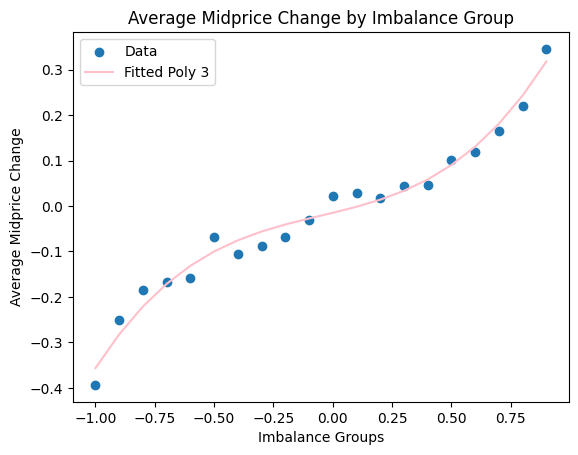

[ 0.25595057  0.04047296  0.12627636 -0.01489497]


In [12]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

# Define the function to fit
def linear(x, m, b):
    return m*x + b

def poly3(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

# Prepare the data
xdata = imbalance_groups
ydata = midprice_averages


# Fit the curve
popt3, _ = curve_fit(poly3, xdata, ydata)
y_fit3 = poly3(xdata, *popt3)



# Plot the original data and the fitted curve
plt.scatter(xdata, ydata, label='Data')
plt.plot(xdata, y_fit3, label='Fitted Poly 3', color='pink')

plt.xlabel('Imbalance Groups')
plt.ylabel('Average Midprice Change')
plt.title('Average Midprice Change by Imbalance Group')
plt.legend()

plt.show()
print(popt3)


In [13]:
books["best_bid"]  = np.array(books["bid_0_price"])
books["best_ask"] = np.array(books["ask_0_price"])
midprice = np.array(books["mid"])

#to plot we subtract the mid
books["best_bid"] = books["best_bid"] - books["mid"]
books["best_ask"] = books["best_ask"] - books["mid"]
books["spread"] = (books["best_ask"]-books["best_bid"])

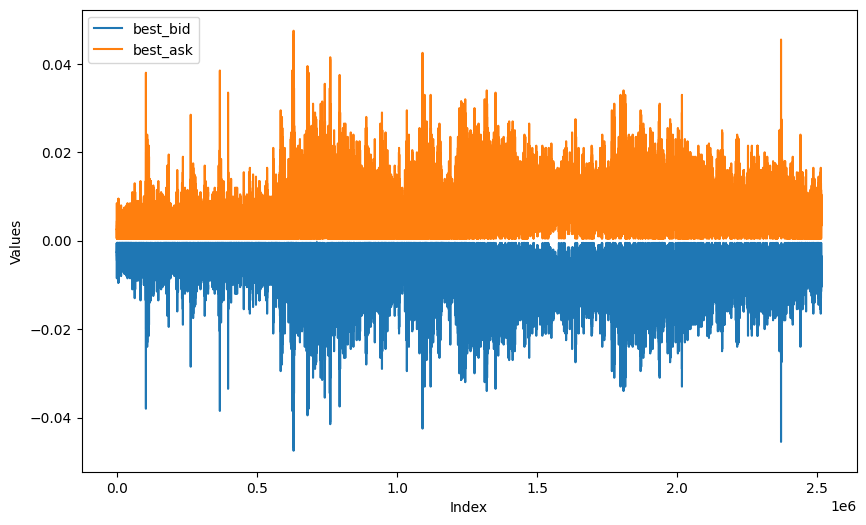

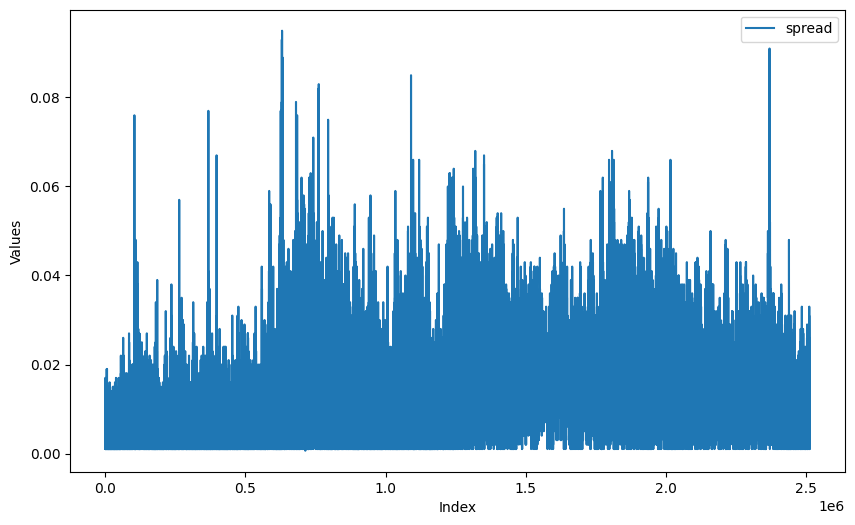

In [14]:
columns_to_plot = ["best_bid", "best_ask"]

books[columns_to_plot].plot(figsize=(10, 6)) 
plt.xlabel("Index")
plt.ylabel("Values")
plt.show()

#####
columns_to_plot = ["spread"]

books[columns_to_plot].plot(figsize=(10, 6)) 
plt.xlabel("Index")
plt.ylabel("Values")
plt.show()

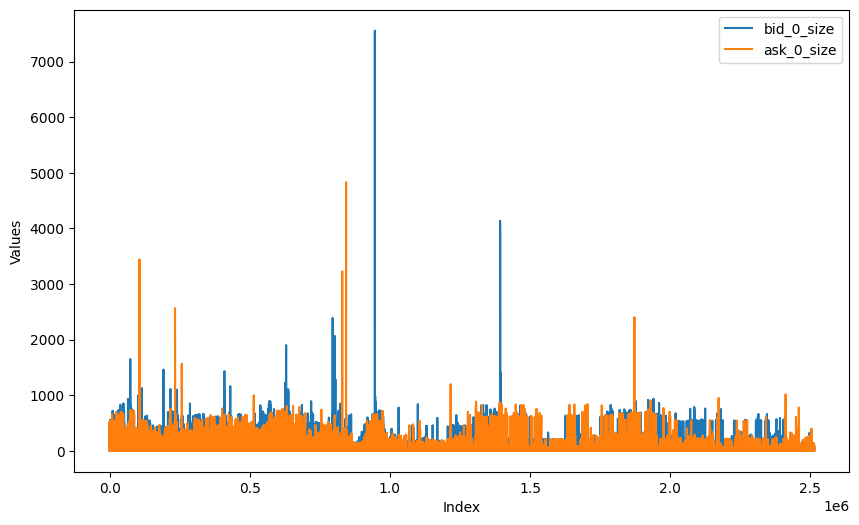

In [15]:
#size best bid ask
columns_to_plot = ["bid_0_size", "ask_0_size"]

books[columns_to_plot].plot(figsize=(10, 6)) 
plt.xlabel("Index")
plt.ylabel("Values")
plt.show()

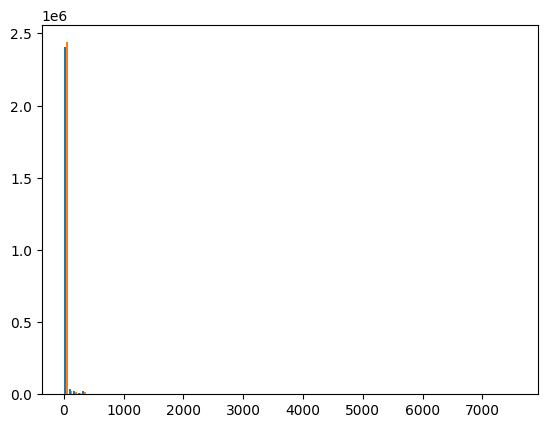

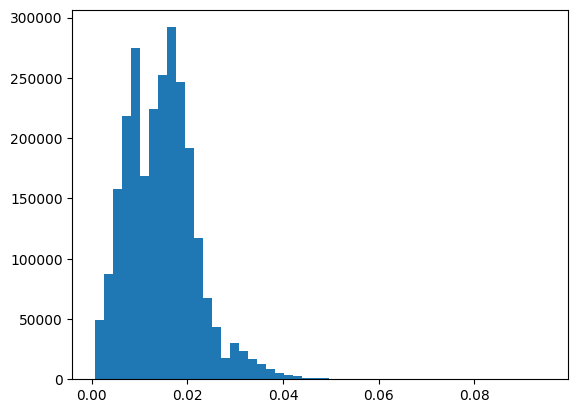

In [16]:
#Now let’s look at it’s distribution:
plt.hist([books['bid_0_size'],books['ask_0_size']], bins=100)
plt.show()

plt.hist([books['spread']], bins=50)
plt.show()

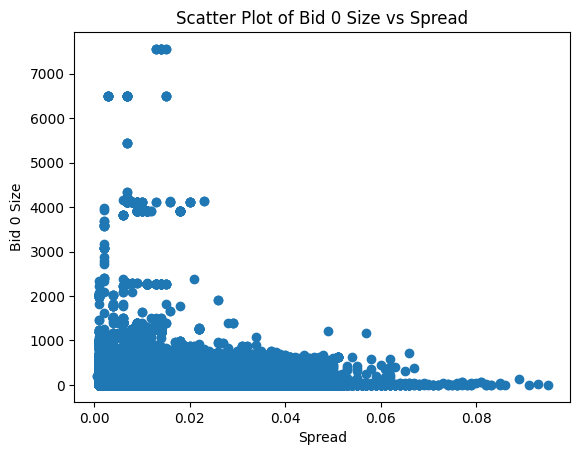

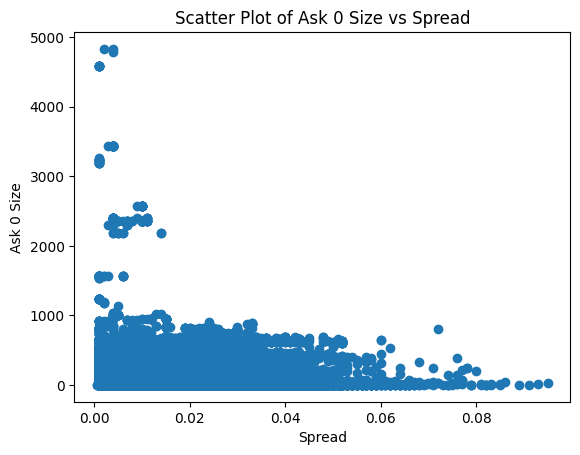

In [17]:
# spread vs ordersize

# Create the scatter plot
plt.scatter(books["spread"], books["bid_0_size"])
plt.xlabel("Spread")
plt.ylabel("Bid 0 Size")
plt.title("Scatter Plot of Bid 0 Size vs Spread")
plt.show()

# Create the scatter plot
plt.scatter(books["spread"], books["ask_0_size"])
plt.xlabel("Spread")
plt.ylabel("Ask 0 Size")
plt.title("Scatter Plot of Ask 0 Size vs Spread")
plt.show()

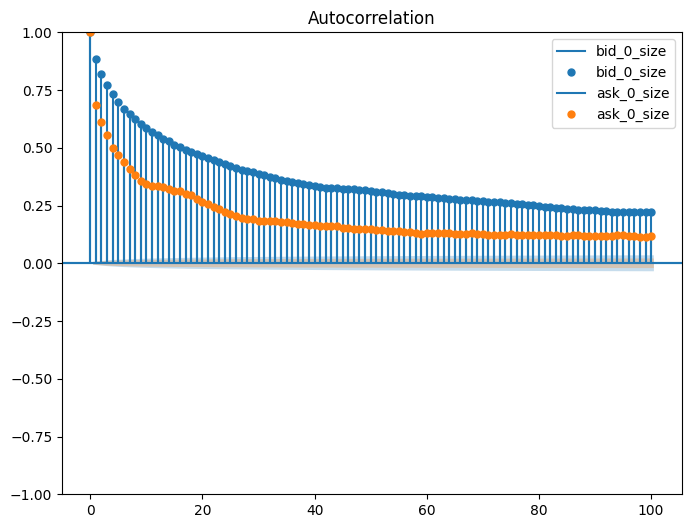

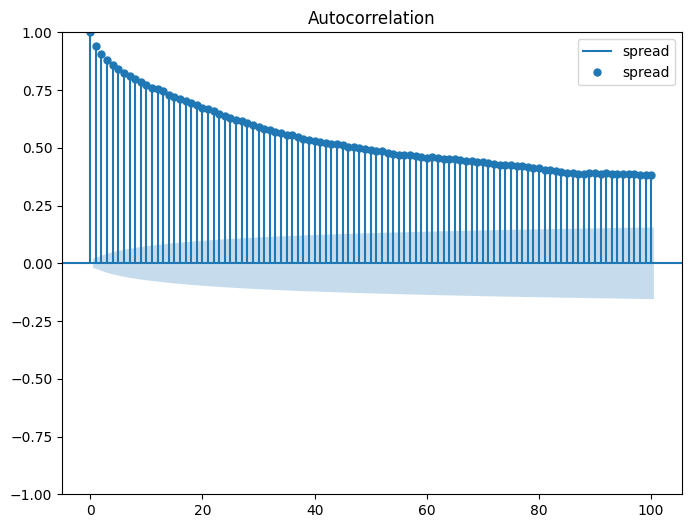

In [18]:
#autocorrealtion
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the ACF of 'ob_imbalance_1' on the plot
sm.graphics.tsa.plot_acf(books['bid_0_size'][-100000:], lags=100, ax=ax, label='bid_0_size')
sm.graphics.tsa.plot_acf(books['ask_0_size'][-100000:], lags=100, ax=ax, label='ask_0_size')

# Add a legend to distinguish the plots
ax.legend()

# Show the plot
plt.show()

#####
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the ACF of 'ob_imbalance_1' on the plot
sm.graphics.tsa.plot_acf(books['spread'][-10000:], lags=100, ax=ax, label='spread')

# Add a legend to distinguish the plots
ax.legend()

# Show the plot
plt.show()

### Market Orders

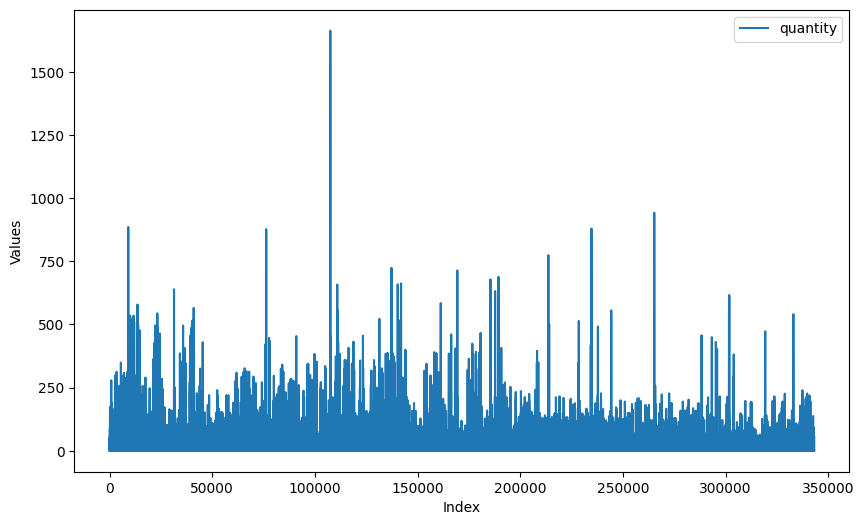

In [19]:
#size over time
columns_to_plot = ["quantity"]

trades[columns_to_plot].plot(figsize=(10, 6)) 
plt.xlabel("Index")
plt.ylabel("Values")
plt.show()

we can observe the sizes follow an AutoRegressive process of order 1. meaning values at time t are linearly dependent on valueas at t -1

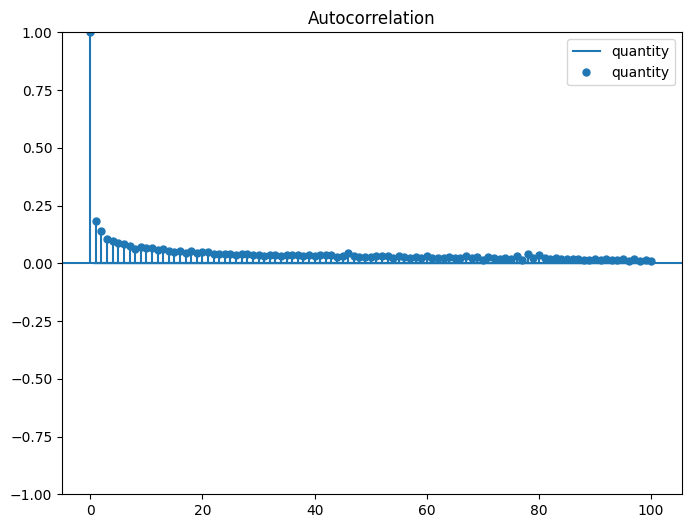

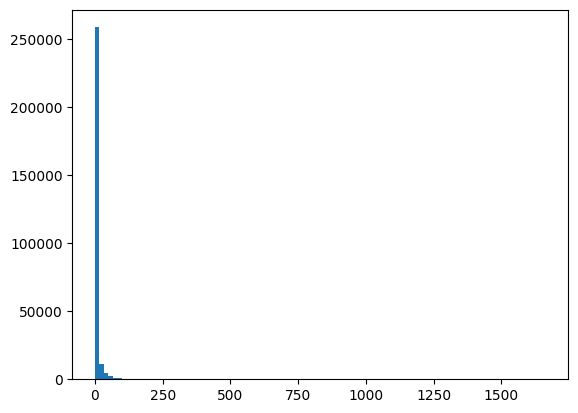

In [20]:
#autocorrealtion
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the ACF of 'ob_imbalance_1' on the plot
sm.graphics.tsa.plot_acf(trades['quantity'][-100000:], lags=100, ax=ax, label='quantity')

# Add a legend to distinguish the plots
ax.legend()

# Show the plot
plt.show()


plt.hist([trades['quantity']], bins=100)
plt.show()

Let's examine the likelihood of consecutive occurrences of the same side order.

In [21]:
# taker buy gets followed by other buy orders?

#count the occurances of same side trades following each other. 
# filter out big trades (same timestamp, and same side following each other)
trades.rename(columns={'origin_time_x': 'origin_time'}, inplace=True)

buy_buy = len(trades[(trades['side'] == 'buy') & (trades['side'].shift(-1) == 'buy') & (trades['origin_time'] != trades['origin_time'].shift(-1))])
buy_sell = len(trades[(trades['side'] == 'buy') & (trades['side'].shift(-1) == 'sell') & (trades['origin_time'] != trades['origin_time'].shift(-1))])
sell_sell = len(trades[(trades['side'] == 'sell') & (trades['side'].shift(-1) == 'sell') & (trades['origin_time'] != trades['origin_time'].shift(-1))])
sell_buy = len(trades[(trades['side'] == 'sell') & (trades['side'].shift(-1) == 'buy') & (trades['origin_time'] != trades['origin_time'].shift(-1))])

probability_buy_buy = buy_buy / (buy_sell+buy_buy)
probability_sell_sell = sell_sell / (sell_buy+sell_sell)
probability_same_side = (buy_buy + sell_sell) / (sell_buy+sell_sell+buy_sell+buy_buy)

print(f"buy_buy: {buy_buy}")
print(f"buy_sell: {buy_sell}")
print(f"sell_sell: {sell_sell}")
print(f"sell_buy: {sell_buy}")
print("")
print(f"probability_buy_buy: {probability_buy_buy}")
print(f"probability_sell_sell: {probability_sell_sell}")
print(f"probability_same_side: {probability_same_side}")


buy_buy: 59153
buy_sell: 46132
sell_sell: 87848
sell_buy: 46153

probability_buy_buy: 0.5618369188393408
probability_sell_sell: 0.6555771971850957
probability_same_side: 0.6143318037829208


### Maker - Taker Dynamics

In [22]:
# limit order size and thaker size should correlate!
#merge results
df = pd.merge_asof(trades, books[["bid_0_size", "ask_0_size","received_time"]].set_index('received_time'), on='received_time', direction='backward') #backward-> no future information

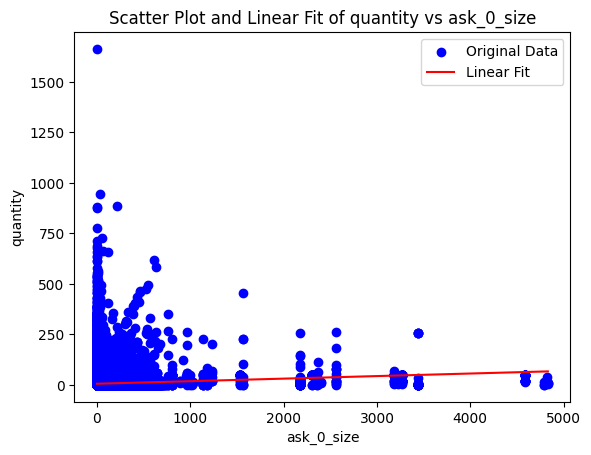

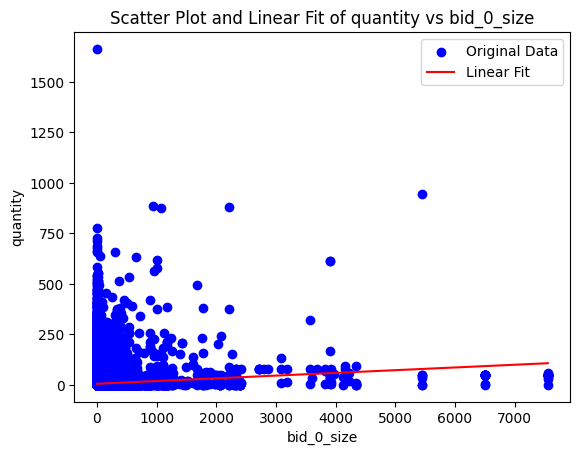

In [23]:

# Define the linear fit function
def lin_fit(x, a, b):
    return a * x + b

ask_0_size = np.array(df["ask_0_size"])
quantity = np.array(df["quantity"])

# Fit the data using curve_fit
params, _ = curve_fit(lin_fit, ask_0_size, quantity)
x_fit = np.linspace(min(ask_0_size), max(ask_0_size), 100)
y_fit = lin_fit(x_fit, *params)

# Create the scatter plot for original data
plt.scatter(ask_0_size, quantity, label='Original Data', color='blue')
plt.xlabel("ask_0_size")
plt.ylabel("quantity")
plt.title("Scatter Plot and Linear Fit of quantity vs ask_0_size")

# Plot the fitted curve
plt.plot(x_fit, y_fit, label='Linear Fit', color='red')
plt.legend()
plt.show()



bid_0_size = np.array(df["bid_0_size"])
quantity = np.array(df["quantity"])
params, _ = curve_fit(lin_fit, bid_0_size, quantity)

# Generate fitted data for plotting
x_fit = np.linspace(min(bid_0_size), max(bid_0_size), 100)
y_fit = lin_fit(x_fit, *params)

# Create the scatter plot for original data
plt.scatter(bid_0_size, quantity, label='Original Data', color='blue')
plt.xlabel("bid_0_size")
plt.ylabel("quantity")
plt.title("Scatter Plot and Linear Fit of quantity vs bid_0_size")

# Plot the fitted curve
plt.plot(x_fit, y_fit, label='Linear Fit', color='red')
plt.legend()
plt.show()

In [24]:
#what are the correlations
print(np.corrcoef(df["ask_0_size"], df["quantity"])[0][1])
print(np.corrcoef(df["bid_0_size"], df["quantity"])[0][1])

0.08161815676833682
0.09821336695928856


## Order Arrival rate and Volume Synchronized Probability of Informed Trading

In [25]:
trades.set_index('received_time', inplace=True)
trades['buy_volume'] = trades.apply(lambda row: row['quantity'] if row['side'] == 'buy' else 0, axis=1)
trades['sell_volume'] = trades.apply(lambda row: row['quantity'] if row['side'] == 'sell' else 0, axis=1)
window_size = '600s'
trades['rolling_buy_volume'] = trades['buy_volume'].rolling(window_size).sum()
trades['rolling_sell_volume'] = trades['sell_volume'].rolling(window_size).sum()
#df['rolling_difference'] = df['rolling_buy_volume'] - df['rolling_sell_volume']

trades['vpin'] = (trades["rolling_buy_volume"]-trades["rolling_sell_volume"])/(trades["rolling_buy_volume"]+trades["rolling_sell_volume"])
trades.reset_index(inplace=True)


In [26]:

#merge results
books = pd.merge_asof(books, trades[["received_time","vpin"]].set_index('received_time'), on='received_time', direction='backward') #backward-> no future information

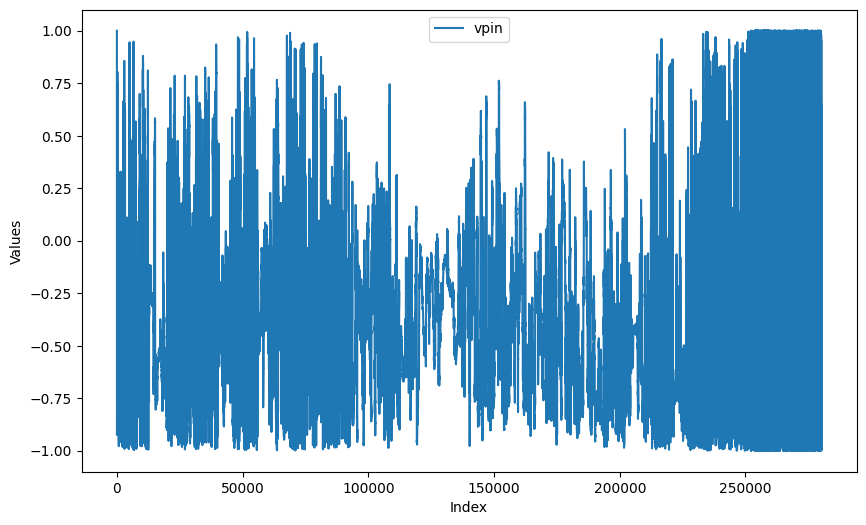

In [27]:
columns_to_plot = ["vpin"]

trades[columns_to_plot].plot(figsize=(10, 6)) 
plt.xlabel("Index")
plt.ylabel("Values")
plt.show()

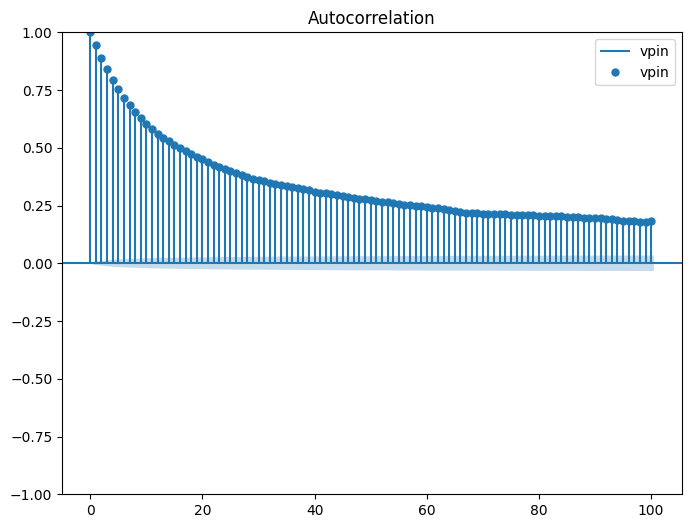

In [28]:
#autocorrealtion
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the ACF of 'ob_imbalance_1' on the plot
sm.graphics.tsa.plot_acf(trades['vpin'][-100000:], lags=100, ax=ax, label='vpin')

# Add a legend to distinguish the plots
ax.legend()

# Show the plot
plt.show()

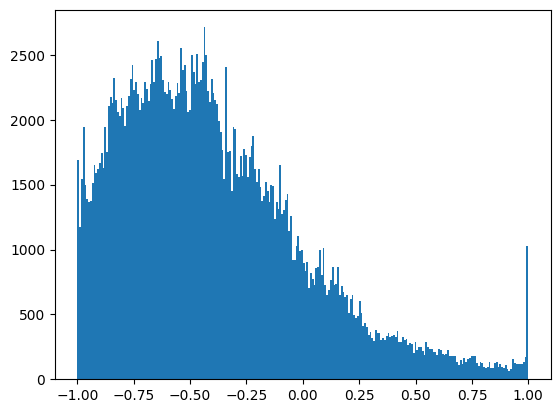

In [29]:
#Now let’s look at it’s distribution:
plt.hist([trades['vpin']], bins=250)
plt.show()

/var/folders/tk/17g1mb057qd17rjwhx9x88p40000gp/T/ipykernel_29174/1246080412.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  midprice_averages = df.groupby('vpin_group')['midprice_change'].mean().values


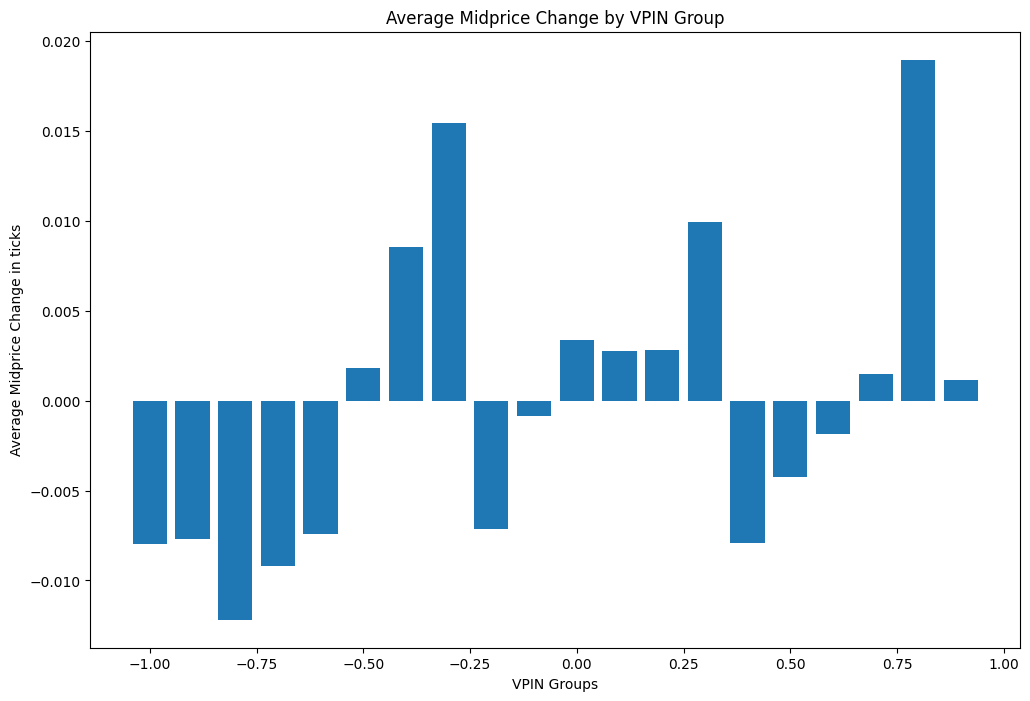

In [30]:
vpin = np.array(books['vpin'])
midprices = np.array(books['mid'])
midprice_change = midprices[1:]-midprices[:-1]

#lets look at the avg midprice change for these vpin buckets
df = pd.DataFrame({'vpin': vpin[:-1], 'midprice_change': midprice_change / tick_size})

# Define the bins
bins = np.arange(-1, 1.1, 0.1)  # Adding 0.1 to include the upper bound
df['vpin_group'] = pd.cut(df['vpin'], bins=bins)
midprice_averages = df.groupby('vpin_group')['midprice_change'].mean().values

# Your imbalance_groups remain the same
imbalance_groups = np.arange(-1, 1., 0.1)
# Plotting
plt.figure(figsize=(12, 8))
plt.bar(imbalance_groups, midprice_averages, width=0.08)  # Adjusted width to match new granularity
plt.xlabel('VPIN Groups')
plt.ylabel('Average Midprice Change in ticks')
plt.title('Average Midprice Change by VPIN Group')
plt.show()

## order book depth

In [31]:
def calculate_depth(row):

        amount_of_rows = 5
        bid_amount_row = [row[f"bid_{i}_size"] for i in range(amount_of_rows)]
        ask_amount_row = [row[f"ask_{i}_size"] for i in range(amount_of_rows)]

        #create tick list: bsp 100.1, 100.2, 100.4 -> 1,2,4 ticks
        min_price_step = tick_size
        bid_price_row = [row[f"bid_{i}_price"] for i in range(amount_of_rows)]
        ask_price_row = [row[f"ask_{i}_price"] for i in range(amount_of_rows)]
        ask_price = [(int(round((abs(bid_price_row[i] - bid_price_row[0]) ) / min_price_step))) for i in range(len(bid_price_row))]
        ask_price = list(map(lambda x: x+1, ask_price))
        bid_price = [(int(round((abs(ask_price_row[i] - ask_price_row[0]) ) / min_price_step))) for i in range(len(ask_price_row))]
        bid_price = list(map(lambda x: x+1, bid_price))


        y_bid = bid_amount_row
        y_ask = ask_amount_row

        # make it cumaltive
        def cumulative_list(lst):
            cum_lst = []
            cum_sum = 0
            for item in lst:
                cum_sum += item
                cum_lst.append(cum_sum)
            return cum_lst

        y_bid = cumulative_list(y_bid)
        y_ask = cumulative_list(y_ask)

        # Filter out NaN values for y_bid
        filtered_y_bid = [y for y in y_bid if not np.isnan(y)]

        # Filter out NaN values for y_ask
        filtered_y_ask = [y for y in y_ask if not np.isnan(y)]

        def linear_func(x, b, a):
            return a * x + b

        # Fit linear regression for y_bid
        params_bid, _ = curve_fit(linear_func, list(range(1, 1 + len(filtered_y_bid))), filtered_y_bid)
        a_bid, b_bid = params_bid

        # Fit linear regression for y_ask
        params_ask, _ = curve_fit(linear_func, list(range(1, 1 + len(filtered_y_ask))), filtered_y_ask)
        a_ask, b_ask = params_ask

        ratio = np.log(b_bid / b_ask)

        return b_bid, b_ask, ratio

progress_result = tqdm(books.apply(calculate_depth, axis=1), total=books.shape[0])

# Now use the progress_result in your zip
books['b_bid'], books['b_ask'], books['b_ratio'] = zip(*list(progress_result))
books['b_imbalance'] = (books['b_bid']-books['b_ask'])/(books['b_bid']+books['b_ask'])

/Users/miguelmeier/opt/anaconda3/envs/ser_env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 2513824/2513824 [00:00<00:00, 4032091.58it/s]


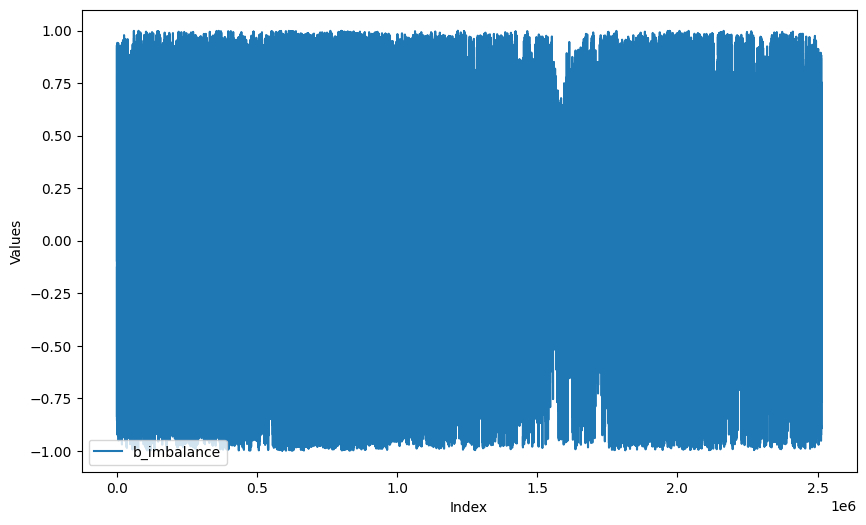

In [32]:
columns_to_plot = ["b_imbalance"]

books[columns_to_plot].plot(figsize=(10, 6)) 
plt.xlabel("Index")
plt.ylabel("Values")
plt.show()

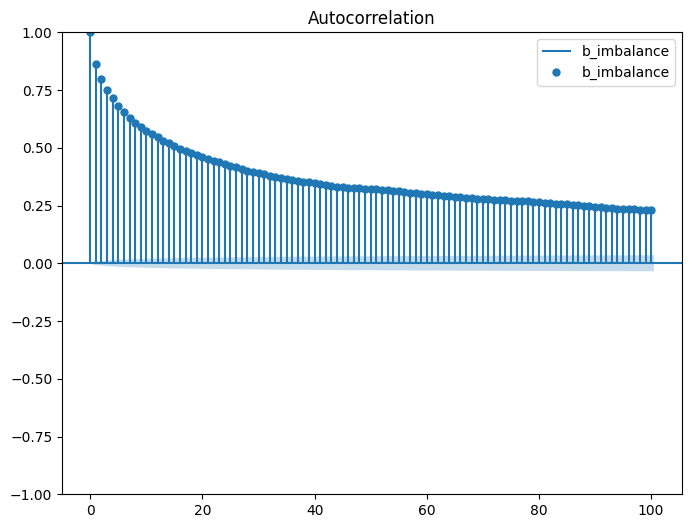

In [33]:
#autocorrealtion
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the ACF of 'ob_imbalance_1' on the plot
sm.graphics.tsa.plot_acf(books['b_imbalance'][-100000:], lags=100, ax=ax, label='b_imbalance')

# Add a legend to distinguish the plots
ax.legend()

# Show the plot
plt.show()

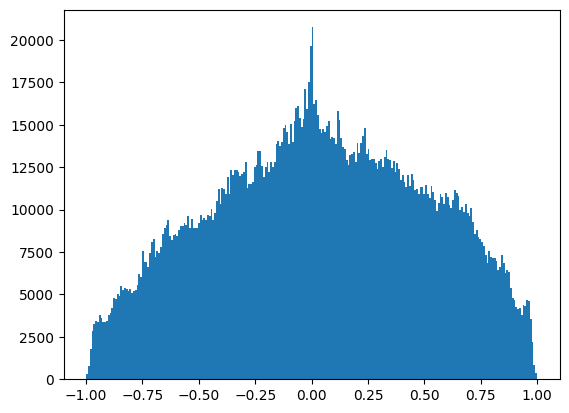

In [34]:
#Now let’s look at it’s distribution:
plt.hist([books['b_imbalance']], bins=250)
plt.show()

/var/folders/tk/17g1mb057qd17rjwhx9x88p40000gp/T/ipykernel_29174/3344801527.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  midprice_averages = df.groupby('b_imbalance_group')['midprice_change'].mean().values


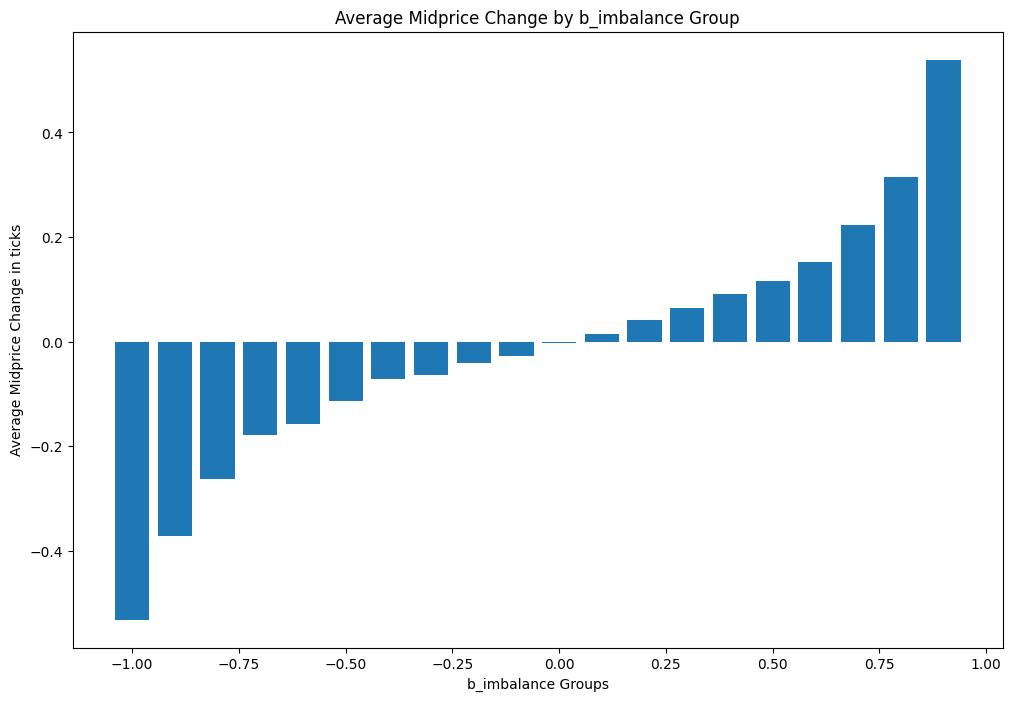

In [35]:
b_imbalance = np.array(books['b_imbalance'])
midprices = np.array(books['mid'])
midprice_change = midprices[1:]-midprices[:-1]

#lets look at the avg midprice change for these vpin buckets
df = pd.DataFrame({'b_imbalance': b_imbalance[:-1], 'midprice_change': midprice_change / tick_size})

# Define the bins
bins = np.arange(-1, 1.1, 0.1)  # Adding 0.1 to include the upper bound
df['b_imbalance_group'] = pd.cut(df['b_imbalance'], bins=bins)
midprice_averages = df.groupby('b_imbalance_group')['midprice_change'].mean().values

# Your imbalance_groups remain the same
imbalance_groups = np.arange(-1, 1., 0.1)
# Plotting
plt.figure(figsize=(12, 8))
plt.bar(imbalance_groups, midprice_averages, width=0.08)  # Adjusted width to match new granularity
plt.xlabel('b_imbalance Groups')
plt.ylabel('Average Midprice Change in ticks')
plt.title('Average Midprice Change by b_imbalance Group')
plt.show()

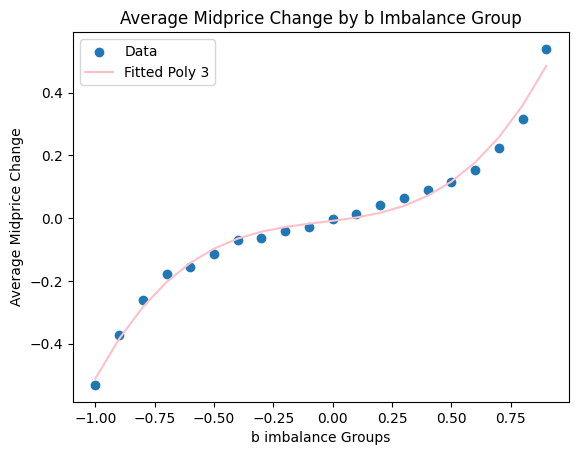

In [36]:
# Define the function to fit
def linear(x, m, b):
    return m*x + b

def poly3(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

# Prepare the data
xdata = imbalance_groups
ydata = midprice_averages


# Fit the curve
popt3, _ = curve_fit(poly3, xdata, ydata)
y_fit3 = poly3(xdata, *popt3)



# Plot the original data and the fitted curve
plt.scatter(xdata, ydata, label='Data')
plt.plot(xdata, y_fit3, label='Fitted Poly 3', color='pink')

plt.xlabel('b imbalance Groups')
plt.ylabel('Average Midprice Change')
plt.title('Average Midprice Change by b Imbalance Group')
plt.legend()

plt.show()

## limit order arrival and deletion rate

In [37]:
# calc arrival of the first 5 rows of the book

for i in range(5):
    books[f"bid_{i}_size_diff"] = books[f"bid_{i}_size"] - books[f"bid_{i}_size"].shift(+1)
    books[f"ask_{i}_size_diff"] = books[f"ask_{i}_size"] - books[f"ask_{i}_size"].shift(+1)


In [38]:
combined_df = pd.concat([books, trades], ignore_index=True)
sorted_df = combined_df.sort_values(by='received_time')


In [39]:
window = "5S"


sorted_df.set_index('received_time', inplace=True)

# Create a mask for rows where side is not nan and side is 'sell'
mask = (~sorted_df['side'].isna()) & (sorted_df['side'] == 'sell')

# Set quantity to 0 where the mask is False
sorted_df['quantity_buy'] = np.where(mask, sorted_df['quantity'], 0)

# Create a rolling window object
rolling_window = sorted_df.rolling(window)

# Calculate the rolling cumulative sum for the specified columns
sorted_df['bid_diff_sum'] = sorted_df['bid_0_size_diff'] + sorted_df['bid_1_size_diff'] + sorted_df['bid_2_size_diff'] + sorted_df['bid_3_size_diff'] + sorted_df['bid_4_size_diff']

sorted_df['rolling_bid_diff_sum'] = rolling_window['bid_diff_sum'].sum()

# Add the rolling sum of the quantity column to the rolling windows
sorted_df['rolling_bid_diff_sum'] += rolling_window['quantity_buy'].sum()

#same for ask
# Create a mask for rows where side is not nan and side is 'sell'
mask = (~sorted_df['side'].isna()) & (sorted_df['side'] == 'buy')

# Set quantity to 0 where the mask is False
sorted_df['quantity_sell'] = np.where(mask, sorted_df['quantity'], 0)

# Create a rolling window object
rolling_window = sorted_df.rolling(window)

# Calculate the rolling cumulative sum for the specified columns
sorted_df['ask_diff_sum'] = sorted_df['ask_0_size_diff'] + sorted_df['ask_1_size_diff'] + sorted_df['ask_2_size_diff'] + sorted_df['ask_3_size_diff'] + sorted_df['ask_4_size_diff']

sorted_df['rolling_ask_diff_sum'] = rolling_window['ask_diff_sum'].sum()

# Add the rolling sum of the quantity column to the rolling windows
sorted_df['rolling_ask_diff_sum'] += rolling_window['quantity_sell'].sum()

# Reset the index if necessary
sorted_df.reset_index(inplace=True)



In [40]:
#delet trades
sorted_df = sorted_df[sorted_df['trade_id'].isna()]

In [41]:
#calculate imbalance

sorted_df["limit_imbalance"] = (sorted_df['rolling_bid_diff_sum']-sorted_df['rolling_ask_diff_sum'])/(abs(sorted_df['rolling_bid_diff_sum'])+abs(sorted_df['rolling_ask_diff_sum']))

sorted_df['limit_imbalance'] = (2 / (1 + np.exp(-sorted_df['limit_imbalance'])) - 1) *2.1
sorted_df['limit_imbalance'].fillna(0)


/var/folders/tk/17g1mb057qd17rjwhx9x88p40000gp/T/ipykernel_29174/713163156.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_df["limit_imbalance"] = (sorted_df['rolling_bid_diff_sum']-sorted_df['rolling_ask_diff_sum'])/(abs(sorted_df['rolling_bid_diff_sum'])+abs(sorted_df['rolling_ask_diff_sum']))
/var/folders/tk/17g1mb057qd17rjwhx9x88p40000gp/T/ipykernel_29174/713163156.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_df['limit_imbalance'] = (2 / (1 + np.exp(-sorted_df['limit_imbalance']

0          0.000000
1          0.970446
2          0.970446
3          0.000000
4          0.970446
             ...   
2794025    0.970446
2794026    0.970446
2794027    0.970446
2794028    0.970446
2794029    0.970446
Name: limit_imbalance, Length: 2513824, dtype: float64

In [42]:
sorted_df.head()

,received_time,origin_time,sequence_number,bid_0_price,bid_0_size,bid_1_price,bid_1_size,bid_2_price,bid_2_size,bid_3_price,...,sell_volume,rolling_buy_volume,rolling_sell_volume,quantity_buy,bid_diff_sum,rolling_bid_diff_sum,quantity_sell,ask_diff_sum,rolling_ask_diff_sum,limit_imbalance
0,2022-11-01 12:52:26.793037312,1970-01-01,2.473485e+09,19.142,0.1694,19.140,166.9343,19.137,38.1314,19.133,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN
1,2022-11-01 12:52:27.143308032,1970-01-01,2.473485e+09,19.142,0.1694,19.140,166.9343,19.137,38.1314,19.133,...,NaN,NaN,NaN,0.0,0.0000,0.0000,0.0,-166.8600,-166.8600,0.970446
2,2022-11-01 12:52:27.250262016,1970-01-01,2.473485e+09,19.142,0.1694,19.140,166.9343,19.137,38.1314,19.133,...,NaN,NaN,NaN,0.0,0.0000,0.0000,0.0,0.0000,-166.8600,0.970446
3,2022-11-01 12:52:27.353878016,1970-01-01,2.473485e+09,19.142,0.1694,19.140,166.9343,19.137,38.1314,19.133,...,NaN,NaN,NaN,0.0,0.0000,0.0000,0.0,166.8600,0.0000,NaN
4,2022-11-01 15:05:27.077800448,1970-01-01,2.473848e+09,18.791,470.9478,18.789,442.7291,18.781,51.7220,18.779,...,NaN,NaN,NaN,0.0,660.8714,660.8714,0.0,-499.5321,-499.5321,0.970446


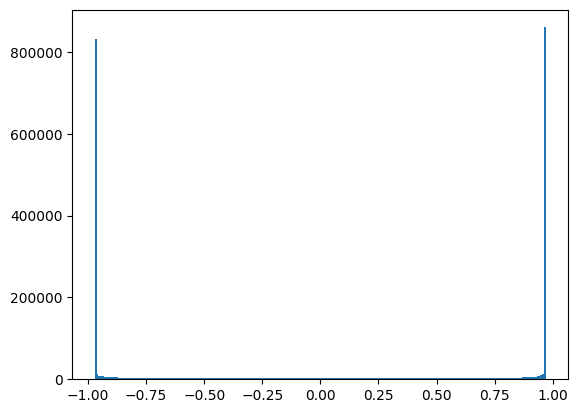

In [43]:
plt.hist([sorted_df['limit_imbalance']], bins=250)
plt.show()

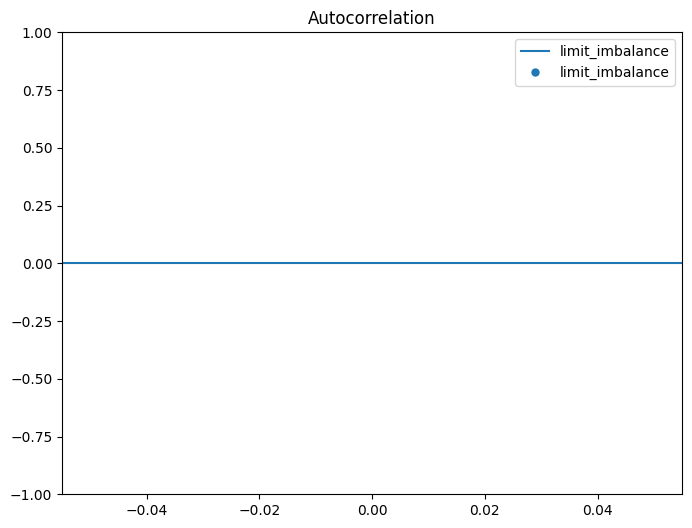

In [44]:
#autocorrealtion
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the ACF of 'ob_imbalance_1' on the plot
sm.graphics.tsa.plot_acf(sorted_df['limit_imbalance'][-10000:], lags=100, ax=ax, label='limit_imbalance')

# Add a legend to distinguish the plots
ax.legend()

# Show the plot
plt.show()

/var/folders/tk/17g1mb057qd17rjwhx9x88p40000gp/T/ipykernel_29174/3359702825.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  midprice_averages = df.groupby('b_imbalance_group')['midprice_change'].mean().values


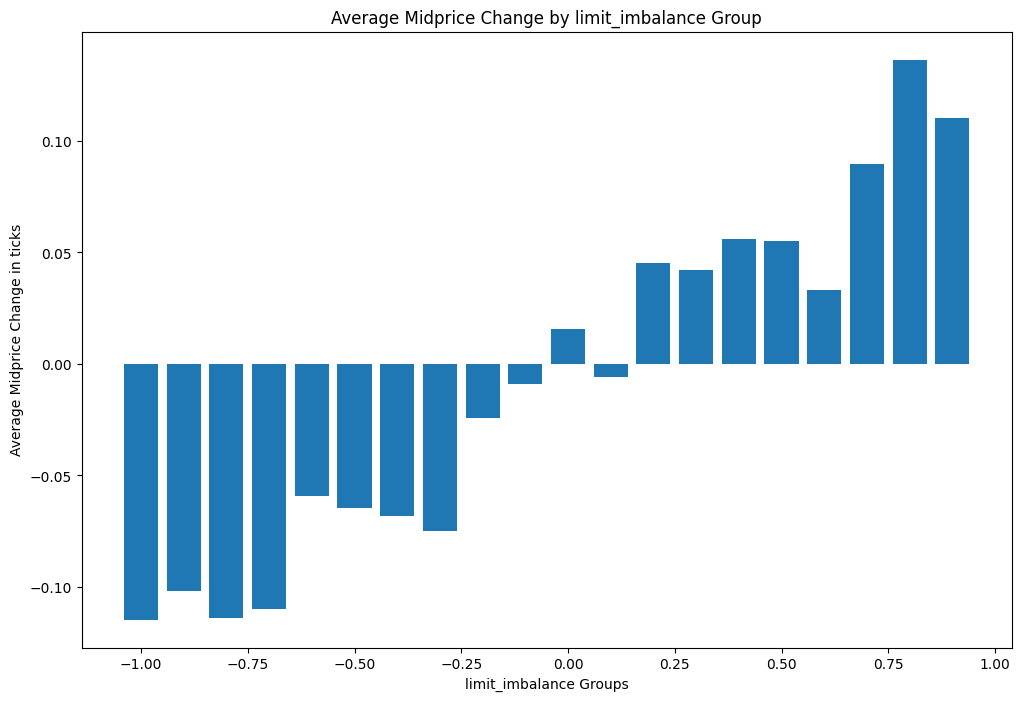

In [45]:
b_imbalance = np.array(sorted_df['limit_imbalance'])
midprices = np.array(sorted_df['mid'])
midprice_change = midprices[1:]-midprices[:-1]

#lets look at the avg midprice change for these vpin buckets
df = pd.DataFrame({'b_imbalance': b_imbalance[:-1], 'midprice_change': midprice_change / tick_size})

# Define the bins
bins = np.arange(-1, 1.1, 0.1)  # Adding 0.1 to include the upper bound
df['b_imbalance_group'] = pd.cut(df['b_imbalance'], bins=bins)
midprice_averages = df.groupby('b_imbalance_group')['midprice_change'].mean().values

# Your imbalance_groups remain the same
imbalance_groups = np.arange(-1, 1., 0.1)
# Plotting
plt.figure(figsize=(12, 8))
plt.bar(imbalance_groups, midprice_averages, width=0.08)  # Adjusted width to match new granularity
plt.xlabel('limit_imbalance Groups')
plt.ylabel('Average Midprice Change in ticks')
plt.title('Average Midprice Change by limit_imbalance Group')
plt.show()

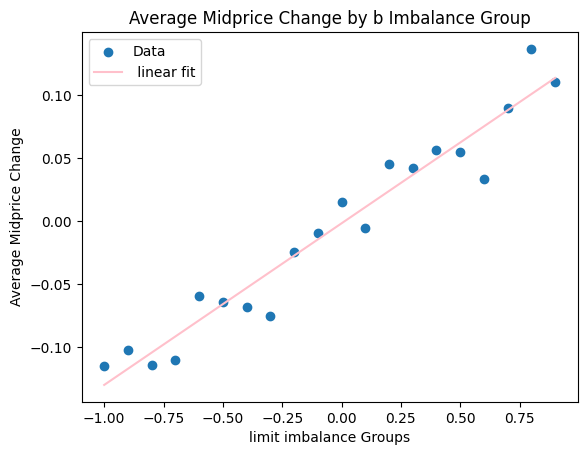

[ 0.12797737 -0.00181614]


In [46]:
# Define the function to fit
def linear(x, m, b):
    return m*x + b

def poly3(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

# Prepare the data
xdata = imbalance_groups
ydata = midprice_averages


# Fit the curve
popt3, _ = curve_fit(linear, xdata, ydata)
y_fit3 = linear(xdata, *popt3)


# Plot the original data and the fitted curve
plt.scatter(xdata, ydata, label='Data')
plt.plot(xdata, y_fit3, label=' linear fit', color='pink')

plt.xlabel('limit imbalance Groups')
plt.ylabel('Average Midprice Change')
plt.title('Average Midprice Change by b Imbalance Group')
plt.legend()

plt.show()
print(popt3)